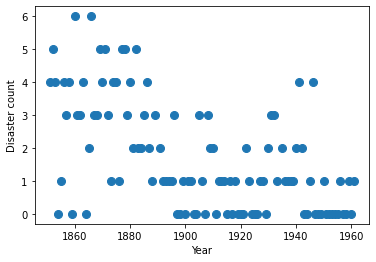

In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [3]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper = years.max(),testval=1900)



    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [4]:
with disaster_model:
    trace = pm.sample(1000)
    prior = pm.sample_prior_predictive(1000)
    posterior = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea3c287fd0>,
      dtype=object)

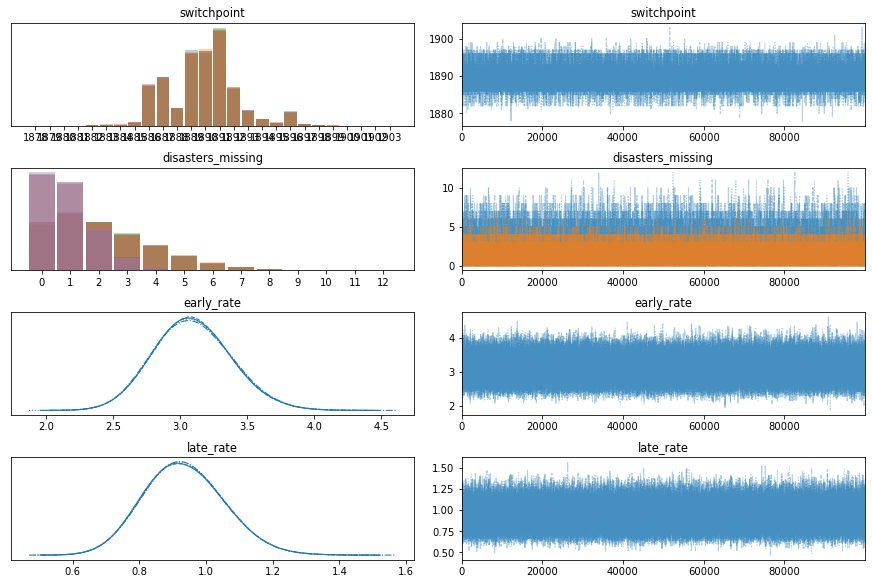

In [143]:
pm.traceplot(trace)

In [5]:
import arviz as az
import panel as pn

with disaster_model:
    pm_data = az.from_pymc3(
            trace=trace,
            prior=prior,
            posterior_predictive=posterior,
    )

In [15]:
pm_data.observed_data


<xarray.Dataset>
Dimensions:          (disasters_dim_0: 111)
Coordinates:
  * disasters_dim_0  (disasters_dim_0) int64 0 1 2 3 4 5 ... 106 107 108 109 110
Data variables:
    disasters        (disasters_dim_0) float64 4.0 5.0 4.0 0.0 ... 1.0 0.0 1.0
Attributes:
    created_at:                 2020-07-28T09:31:41.672676
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.2

In [76]:
from matplotlib.backends.backend_agg import FigureCanvas
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.layouts import gridplot, column, layout

def prior_density_plot(variable="switchpoint"):
    az.style.use("arviz-darkgrid")
    # figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
    # ax = bkp.figure(**figure_kwargs)
    plot = az.plot_density(pm_data, group='prior', var_names=variable, backend='bokeh',shade=.5, show=False)
    grid = layout(plot[0].tolist())
    return grid

def posterior_density_plot(variable="switchpoint"):
    az.style.use("arviz-darkgrid")
    # figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
    # ax = bkp.figure(**figure_kwargs)
    plot = az.plot_density(pm_data, group='posterior', var_names=variable, backend='bokeh',shade=.5, show=False)
    grid = layout(plot[0].tolist())
    return grid


def prior_predictive_density_plot(variable="switchpoint"):
    az.style.use("arviz-darkgrid")
    figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
    ax = bkp.figure(**figure_kwargs)
    az.plot_ppc(pm_data, group='prior', var_names=variable, backend='bokeh', show=False, ax=ax)
    return ax

def posterior_predictive_density_plot(variable="switchpoint"):
    az.style.use("arviz-darkgrid")
    figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
    ax = bkp.figure(**figure_kwargs)
    az.plot_ppc(pm_data, group='posterior', var_names=variable, backend='bokeh', show=False, ax=ax)
    return ax


def sample_trace_plot(variable="switchpoint"):
    az.style.use("arviz-darkgrid")
    # figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
    # ax = bkp.figure(**figure_kwargs)
    plot = az.plot_trace(pm_data, var_names=variable, backend='bokeh', show=False)
    grid = layout(plot[0].tolist())
    return grid

In [62]:
# az.style.use("arviz-darkgrid")
# figure_kwargs = dict(plot_height=500, plot_width=500, tools="pan,wheel_zoom,box_zoom,reset,hover")
# ax = bkp.figure(**figure_kwargs)
plot = az.plot_density(pm_data, group='posterior', var_names='disasters_missing', backend='bokeh',shade=.5, show=False)
# print(plot)
# plot = np.array(plot[0])
# print(plot)
# plot = plot[0].tolist()
print(plot[0][0])
print(plot[0][1])
grid = layout(plot[0].tolist())
pn.serve(grid)

Figure(id='624946', ...)
Figure(id='624982', ...)
Launching server at http://localhost:54227


In [79]:
from bokeh.plotting import show



pn.extension()

def prior_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior.data_vars)))
    i = pn.interact(prior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i))
    return p



def posterior_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)))
    i = pn.interact(posterior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def prior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior_predictive.data_vars)))
    i = pn.interact(prior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i))
    return p

def posterior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior_predictive.data_vars)))
    i = pn.interact(posterior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i))
    return p

def sample_trace_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)))
    i = pn.interact(sample_trace_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i))
    return p

In [80]:
tabs = pn.Tabs(('Prior', prior_view_tab),('Prior Predictive', prior_predictive_view_tab),('Posterior', posterior_view_tab),('Posterior Predictive',posterior_predictive_view_tab),('Sample Trace', sample_trace_view_tab))
pn.serve(tabs)

Launching server at http://localhost:55355
